<a href="https://colab.research.google.com/github/FarizKesten/ChallengeAccepted/blob/main/IntrusionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks:
1. Training: Build a detection model that can detect footsteps and fence climbing given the provided data.
2. Inference: Implement a prototype that can read DAS data, run the detection model and output when
and where in the provided data footsteps resp. fence climbing occurs.
3. Visualize the output of the prototype in some way and evaluate the real-time capability of the prototype.
4. Given a few samples from a different installation, evaluate and (if necessary) adjust such that the
detection still works.

In [29]:
# Adding neccesary libraries
#!pip install -q segmentation-models-pytorch
#import segmentation_models_pytorch as smp

import os
import glob
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler


import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
'''
PATH-ACCESS

For convenience I saved all the data from the E-Mail to my Drive,
however I keep it public so that no one from outside could retrieve it. I can give acces to the Drive if neccessary
Otherwise, pleas replace the location of the data to run the script
'''

base_path = '/content/drive/MyDrive/ds_challenge'
path_task1 = os.path.join(base_path, 'Task1')
path_task2 = os.path.join(base_path, 'Task2')
path_task4 = os.path.join(base_path, 'Task4')



# Viewing sample images to get better understanding

Viewing the 3 classes as well as inference to understand the current dataset

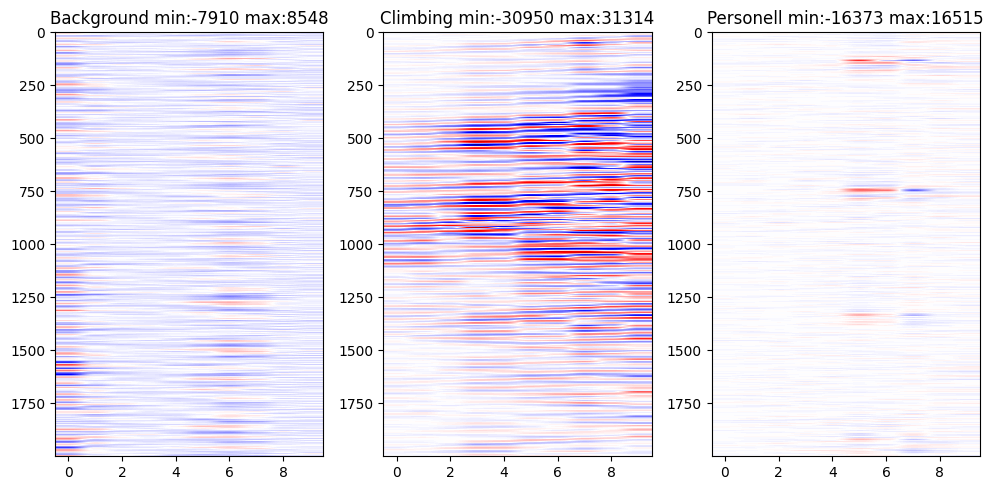

In [69]:
# find all training images

task = path_task1
#task = path_task4

# background
bgd_img = glob.glob(
    os.path.join(task, 'training', 'background', '**', '*.npy'),
    recursive=True
)

# climbing images
clm_img = glob.glob(
    os.path.join(task, 'training', 'climbing', '**', '*.npy'),
    recursive=True
)

# personnel
prs_img = glob.glob(
    os.path.join(task, 'training', 'personnel', '**', '*.npy'),
    recursive=True
)



# try to view 1 image of each class
idx = random.randint(0, min(len(bgd_img) - 1, len(clm_img) - 1, len(prs_img) - 1))
bgd = np.load(bgd_img[idx])
clm = np.load(clm_img[idx])
prs = np.load(prs_img[idx])

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

cmap = 'seismic'
axes[0].imshow(bgd, cmap=cmap, aspect="auto" )
axes[0].set_title(f"Background min:{np.min(bgd)} max:{np.max(bgd)}")
#axes[0].axis('off')

axes[1].imshow(clm, cmap=cmap, aspect="auto")
axes[1].set_title(f"Climbing min:{np.min(clm)} max:{np.max(clm)}")
#axes[1].axis('off')

axes[2].imshow(prs, cmap=cmap, aspect="auto")
axes[2].set_title(f"Personell min:{np.min(prs)} max:{np.max(prs)}")
#axes[2].axis('off')

plt.tight_layout()
plt.show()



<ipython-input-79-0813a8303d27>:10: RuntimeWarning: overflow encountered in scalar subtract
  normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))


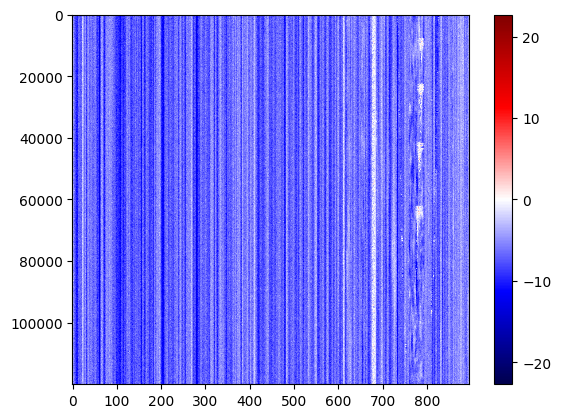

In [79]:
# view inference image

# inference
inf_img = glob.glob(
    os.path.join(path_task2, 'inference', '*.npy'),
    recursive=True
)

image = np.load(inf_img[0])
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.imshow(normalized_image, cmap="seismic", aspect="auto")
plt.colorbar()
plt.show()


# Task 1 : Training

I see this as a segmentation task since we also need to localize the class in the image.

For rapid-prototyping of segmentation models I would use the segmentaiton-models-pytorch library

In [80]:
# install segmentation-models library
import importlib.util

if importlib.util.find_spec('segmentation_models_pytorch') is None:
    !pip install -q segmentation-models-pytorch

import segmentation_models_pytorch as smp


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.3 MB/s eta 0:00:00


In [82]:
# try out multiple model candidates
encoder_name = "resnet34"
encoder_weights = "imagenet"
in_channels=3
classes=3

models = {
    # Klassiker
    "Unet": smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

    # included dense skip connections
    "Unet++": smp.UnetPlusPlus(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

    # Lightweight and Fast
    "FPN": smp.FPN(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

    "PAN": smp.PAN(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=in_channels,
        classes=classes
    ),

}

# printing all models that are used
print("model under tests:")
for key, model in models.items():
  print(key)

model under tests:
Unet
Unet++
FPN
PAN
